## Importing Libraries

In [344]:
import pandas as pd # to handle data
from pycocotools.coco import COCO # wrapper to get data from coco dataset
import numpy as np # library to handle math operations
import matplotlib.pyplot as plt # to visualize data

## Fetching Data from COCO Dataset

In [345]:
def get_person_annotations(img_id, coco):
    """
    Get all annotations of Person objects for a given image
    
    Args:
        img_id: COCO dataset image ID
        coco: COCO API instance
    
    Returns:
        Person objects annotations dictionaries list
    """
    person_cat_id = 1 # id of person objects
    
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=[person_cat_id]) 
    annotations = coco.loadAnns(ann_ids)
    
    return annotations

In [346]:
def process_coco_dataset(annotation_file):
    """
    Processes whole COCO dataset and extracts all Person type annotations.
    
    Args:
        annotation_file: COCO annotations file path
        
    Returns:
        Dictionary with img_id as key and annotations list as value
    """
    coco = COCO(annotation_file)
    
    img_ids = coco.getImgIds()
    
    results = {}
    
    for img_id in img_ids:
        person_annotations = get_person_annotations(img_id, coco)
        if person_annotations: 
            results[img_id] = {
                'image_info': coco.loadImgs(img_id)[0],
                'annotations': person_annotations
            }
    
    return results

In [347]:
def extract_person_details(annotations):
    """
    Extracts detailed informations about people from annotations.
    
    Args:
        annotations: annotations dictionary for an image
        
    Returns:
        List of dictionaries with details for each person
    """
    people = []
    for ann in annotations['annotations']:
        person = {
            'bbox': ann['bbox'],  # [x,y,width,height]
            'area': ann['area'],
            'segmentation': ann['segmentation'],
            'keypoints': ann.get('keypoints', None),
            'num_keypoints': ann.get('num_keypoints', None),
        }
        people.append(person)
    
    return people

For each datum in COCO dataset, extracts details a fills dictionaries with all data regarding people from dataset.

In [348]:
img_width = 640 # width of image samples
img_height = 480 # height of image samples
img_size = img_width * img_height # total size of image samples
annotation_file = 'person_keypoints_train2017.json' # filepath to annotation file

results = process_coco_dataset(annotation_file) 
number_people = {}
single_person = {}

for img_id, data in results.items():
    people = extract_person_details(data)
    number_people[img_id] = len(people)
    for i, person in enumerate(people, 1):
        single_person[f"{img_id}{i}"] = {'ID': f'{img_id}{i}', 'Img': img_id, 'person_num': i, 'num_people': len(people), 'bbox': person['bbox'], 'area': person['area'], 'keypoints': person['keypoints'], 'num_keypoints': person['num_keypoints']}

loading annotations into memory...
Done (t=8.80s)
creating index...
index created!


## Building people DataFrame

From dictionaries initialized above creates DataFrame containing, for each row (each person object inside COCO dataset), person_num (ID of the person inside the image), image_id, x and y position of person object rectangle, width and height of rectangle and area of object.

In [349]:
df = pd.DataFrame.from_dict(single_person, orient='index')
df = df.set_index('ID')

In [350]:
df['x'] = df['bbox'].apply(lambda x: x[0])
df['y'] = df['bbox'].apply(lambda x: x[1])
df['width'] = df['bbox'].apply(lambda x: x[2])
df['height'] = df['bbox'].apply(lambda x: x[3])
df = df.drop(['bbox'], axis=1)


Then cleans scales feature and inserts keypoints visibilities features as DataFrame columns

In [351]:
df['area_norm'] = df['area']/img_size # area normalized to image_size (% of image covered by the object)

In [352]:
face = ["nose_v", "left_eye_v", "right_eye_v", "left_ear_v", "right_ear_v"] # face related keypoints visibilities
body = ["left_shoulder_v", "right_shoulder_v", "left_hip_v", "right_hip_v"] # body related keypoints visibilities
extremities = ["left_elbow_v", "right_elbow_v", "left_wrist_v", "right_wrist_v", "left_knee_v", "right_knee_v", "left_ankle_v", "right_ankle_v"] # extremities related keypoints visibilities

In [353]:
for index, body_part in enumerate(face + body + extremities):
    df[f"{body_part}"] = df['keypoints'].apply(lambda x: (x[index * 3+2])/2) # in order to rescale it on 0-1 range

In [354]:
df['vis_face_ratio'] = df[face].mean(axis=1)
df['vis_body_ratio'] = df[body].mean(axis=1)
df['vis_extremities_ratio'] = df[extremities].mean(axis=1)

????

In [355]:
df.head()

,Img,person_num,num_people,area,keypoints,num_keypoints,x,y,width,height,...,right_elbow_v,left_wrist_v,right_wrist_v,left_knee_v,right_knee_v,left_ankle_v,right_ankle_v,vis_face_ratio,vis_body_ratio,vis_extremities_ratio
ID,,,,,,,,,,,,,,,,,,,,,
3918951,391895,1,2,14107.27130,"[368, 61, 1, 369, 52, 2, 0, 0, 0, 382, 48, 2, ...",14,339.88,22.16,153.88,300.73,...,0.0,0.5,0.5,1.0,1.0,1.0,1.0,0.5,1.000,0.7500
3918952,391895,2,2,708.26055,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,471.64,172.82,35.92,48.10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0000
5224181,522418,1,1,63325.42190,"[497, 118, 2, 495, 92, 2, 0, 0, 0, 594, 51, 2,...",5,382.48,0.00,256.80,474.31,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.250,0.1250
1846131,184613,1,14,11210.37590,"[215, 103, 2, 219, 97, 2, 209, 99, 2, 0, 0, 0,...",16,146.48,65.69,160.83,246.90,...,0.5,1.0,1.0,1.0,1.0,1.0,1.0,0.8,0.875,0.9375
1846132,184613,2,14,4457.00885,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 78, 2, 36, 71,...",14,8.29,57.26,75.33,146.90,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.4,1.000,1.0000


## Creating difficulty measures formulas

#### num_people_diff

In [356]:
def num_people_diff(num_people: int):
    return 1-(1/(num_people+1))

In [357]:
def add_num_people_diff(df):
    df['num_people_diff'] = df['num_people'].apply(num_people_diff)
    return df

#### people_size_diff

In [358]:
def add_people_size_diff(df):
    df['people_size_diff'] = np.minimum(1, 1-df['area_norm'])
    df = df.drop(['area_norm'], axis=1)
    return df

#### visibility_dif

In [359]:
def compute_visibility_dif(df):
    df = df.rename(columns={'vis_face_ratio': 'face_avg_ratio', 'vis_body_ratio': 'body_avg_ratio', 'vis_extremities_ratio': 'extremities_avg_ratio'})
    df['visibility_dif'] = 1-(df['face_avg_ratio']*0.5+df['body_avg_ratio']*0.3+df['extremities_avg_ratio']*0.2) 
    return df

#### offset_diff

In [360]:
def add_offset_diff(df):
    df['offset_diff'] = 0
    return df

#### total_dif

# What's the range?

In [361]:
def add_total_dif(df):
    df['total_dif'] = df['num_people_diff']+df['people_size_diff']+df['visibility_dif']+df['offset_diff']
    return df

## Creating Grouped DataFrames

#### Creates functions in order to build grouped dataframes, based on different parameters (top 75, side 25)

In [ ]:
def create_df(col_name, col_dimension_name, param_num, dimension):
    # return df[(df[col_name])<=(param_num*dimension)] All people whose starting top left keypoint are inside parameters given are counted in the df
    return df[(df[col_name]+df[col_dimension_name])<=(param_num*dimension)] # People whose all figure is inside parameters are counted

In [363]:
def create_grouped_df(df):
    return df[['Img', 'num_people', 'area_norm', 'vis_face_ratio', 'vis_body_ratio', 'vis_extremities_ratio']].groupby('Img').agg({
    'area_norm': 'mean',  
    'num_people': 'count',
    'vis_face_ratio': 'mean',
    'vis_body_ratio': 'mean',
    'vis_extremities_ratio': 'mean',
})

#### all images

In [364]:
all_img_df = create_grouped_df(df)

#### top 75

In [365]:
top_75_df = create_grouped_df(create_df('y', 'height', 0.75, img_height))

#### top 25

In [366]:
top_25_df = create_grouped_df(create_df('y', 'height', 0.25, img_height))

#### top 50

In [367]:
top_50_df = create_grouped_df(create_df('y', 'height', 0.5, img_height))

#### side 25

In [368]:
side_25_df = create_grouped_df(create_df('x', 'width', 0.25, img_width))

#### side 50

In [369]:
side_50_df = create_grouped_df(create_df('x', 'width', 0.5, img_width))

#### side 75

In [370]:
side_75_df = create_grouped_df(create_df('x', 'width', 0.75, img_width))

#### Creates a list with all datasets considered

In [371]:
df_list = [all_img_df, top_25_df, top_50_df, top_75_df, side_25_df, side_50_df, side_75_df]
df_names = ['All', 'Top 25', 'Top 50', 'Top 75', 'Side 25', 'Side 50', 'Side 75']

## Adding visibility metrics to data

In [372]:
for i, (dframe, dname) in enumerate(zip(df_list, df_names)):
    df_list[i] = add_num_people_diff(dframe)
    df_list[i] = add_people_size_diff(df_list[i])
    df_list[i] = compute_visibility_dif(df_list[i])
    df_list[i] = add_offset_diff(df_list[i])
    df_list[i] = add_total_dif(df_list[i])

## Plotting

In [374]:
def plot_hist(df, title):
    plt.bar(df['num_people_diff'].value_counts().keys(), df['num_people_diff'].value_counts().values, width=0.005, color="skyblue", edgecolor="black")
    plt.xlabel("num_people_diff")
    plt.ylabel("Count")
    plt.title(f"{title}")
    plt.grid(axis="y", linestyle="--", alpha=0.7)

### num_people_diff

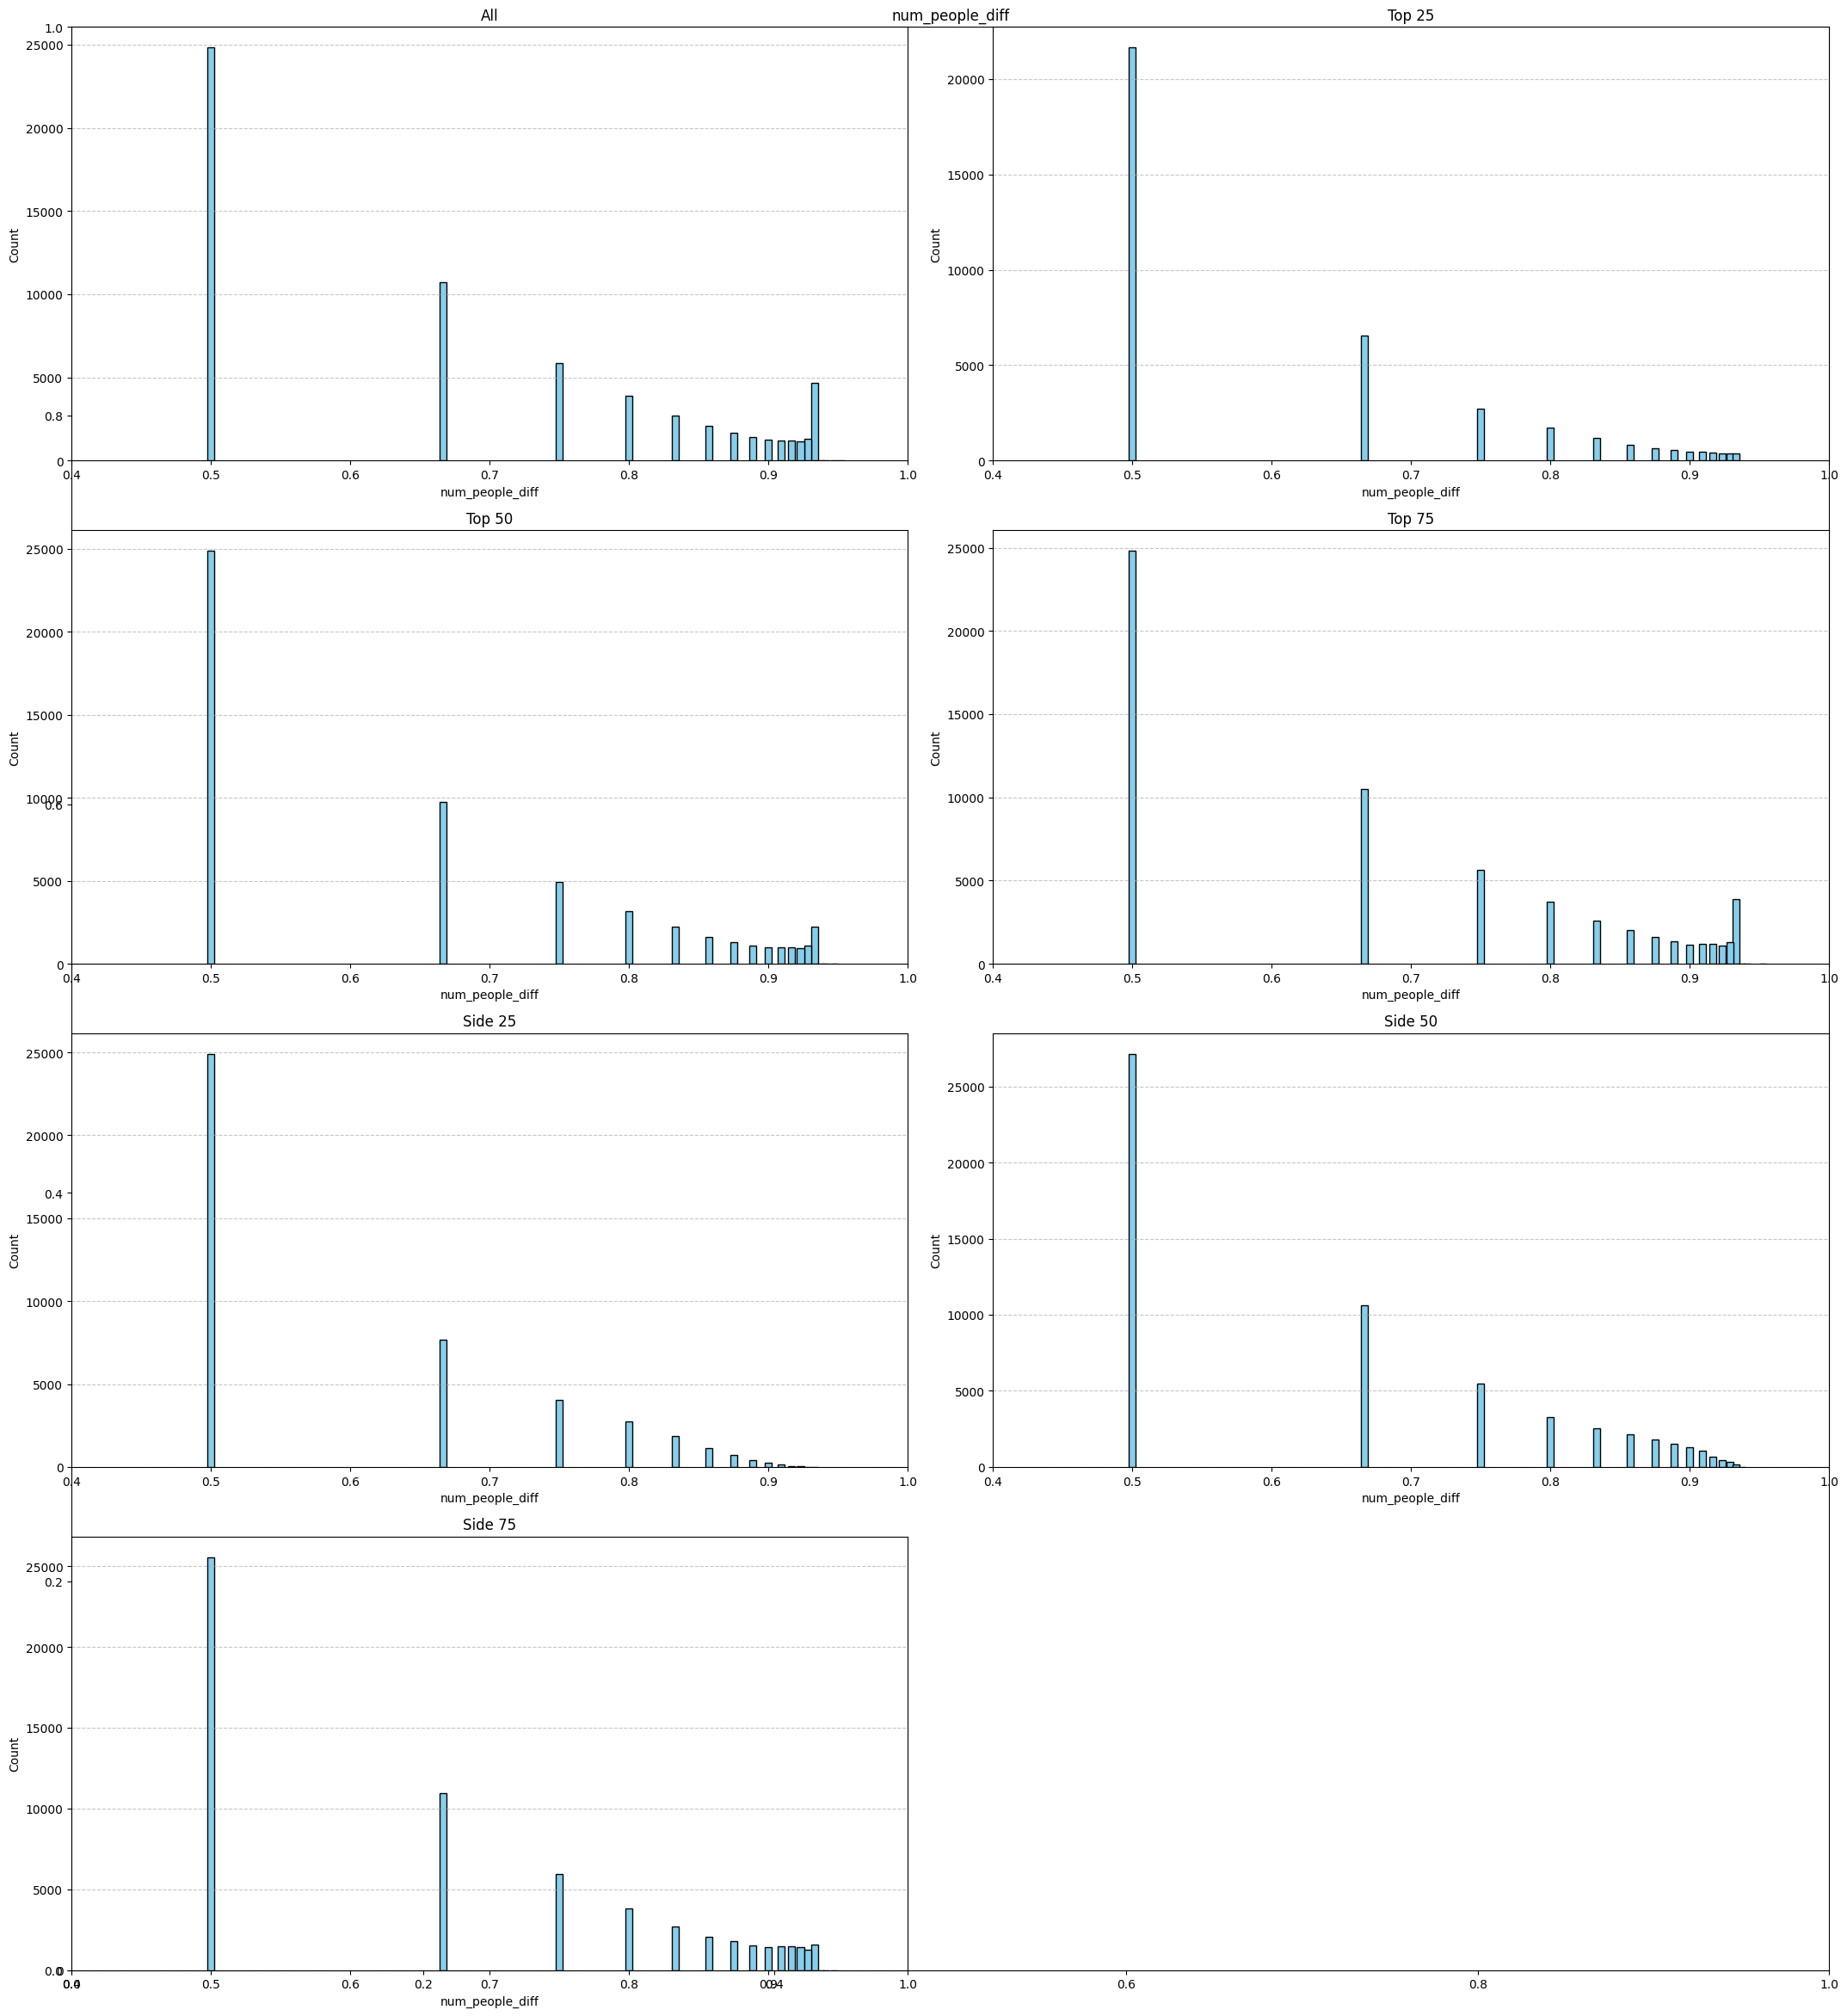

In [375]:
plt.figure(figsize=(22, 24))
plt.title(f"num_people_diff")
for index, data in enumerate(zip(df_list, df_names)):
    ax = plt.subplot(4, 2, index+1)
    plot_hist(data[0], data[1])
    ax.set_xlim(0.4, 1)
plt.tight_layout()

plt.show()

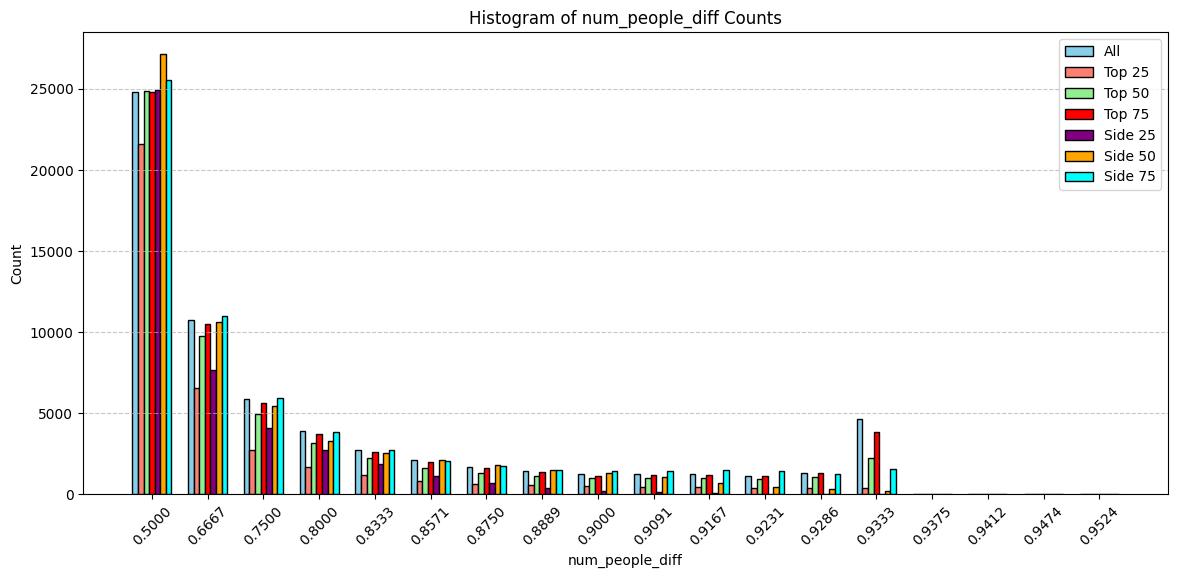

In [376]:
colors = ["skyblue", "salmon", "lightgreen", "red", "purple", "orange", "cyan"]

unique_keys = sorted(set().union(*(df_temp['num_people_diff'].unique() for df_temp in df_list)))
rounded_unique_keys = [f"{key:.4f}" for key in unique_keys]

bar_width = 0.1
x_positions = np.arange(len(unique_keys)) 

plt.figure(figsize=(14, 6))

for i, (df_temp, color) in enumerate(zip(df_list, colors)):
    counts = df_temp['num_people_diff'].value_counts()
    values = [counts.get(key, 0) for key in unique_keys]
    
    offset = (i - (len(df_list) - 1) / 2) * bar_width
    plt.bar(x_positions + offset, values, width=bar_width, color=color, edgecolor="black", label=f"DataFrame {i+1}")

plt.xlabel("num_people_diff")
plt.ylabel("Count")
plt.title("Histogram of num_people_diff Counts")
plt.xticks(x_positions, rounded_unique_keys, rotation=45) 
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(df_names)
plt.show()


### people_size_dif

In [377]:
def plot_people_size_diff(df, title):
    plt.hist(df['people_size_diff'], bins=100, color="skyblue", edgecolor="black", alpha=0.7, density=True)
    plt.xlabel("people_size_diff")
    plt.ylabel("Count")
    plt.title(f"{title}")
    plt.grid(axis="y", linestyle="--", alpha=0.7)

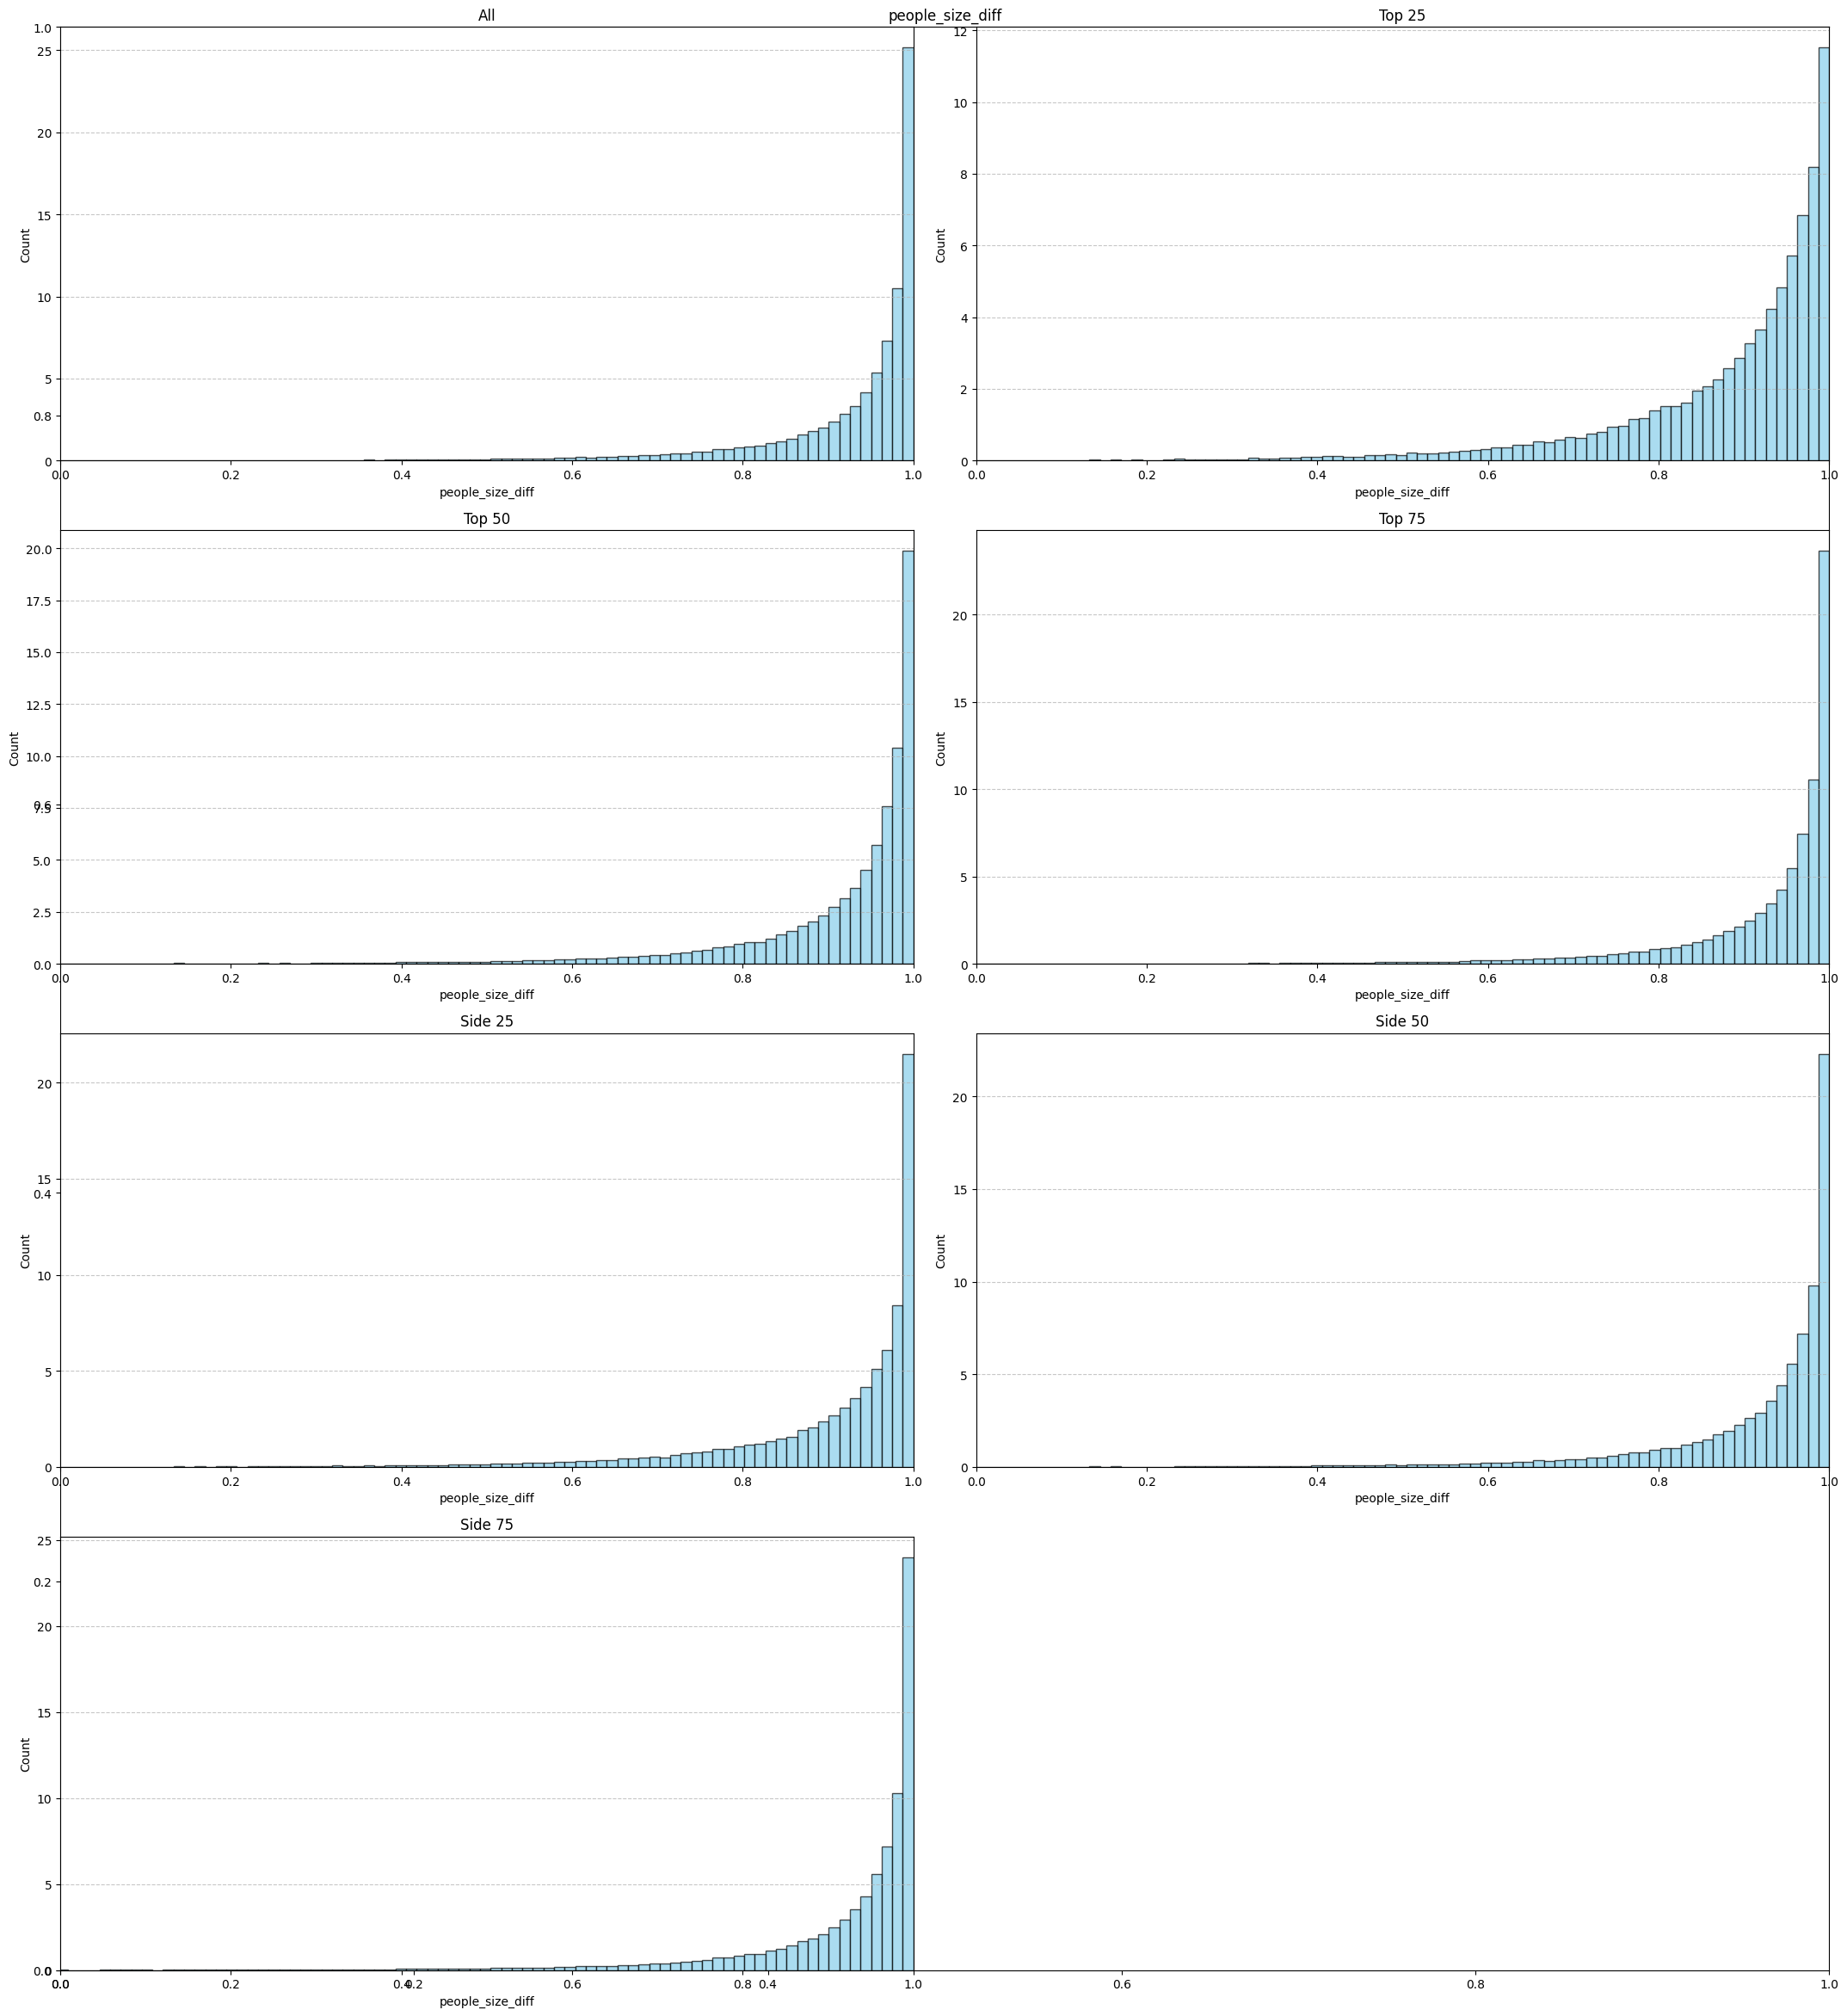

In [378]:
plt.figure(figsize=(22, 24))
plt.title(f"people_size_diff")
for index, data in enumerate(zip(df_list, df_names)):
    ax = plt.subplot(4, 2, index+1)
    plot_people_size_diff(data[0], data[1])
    ax.set_xlim(0, 1)
plt.tight_layout()

plt.show()

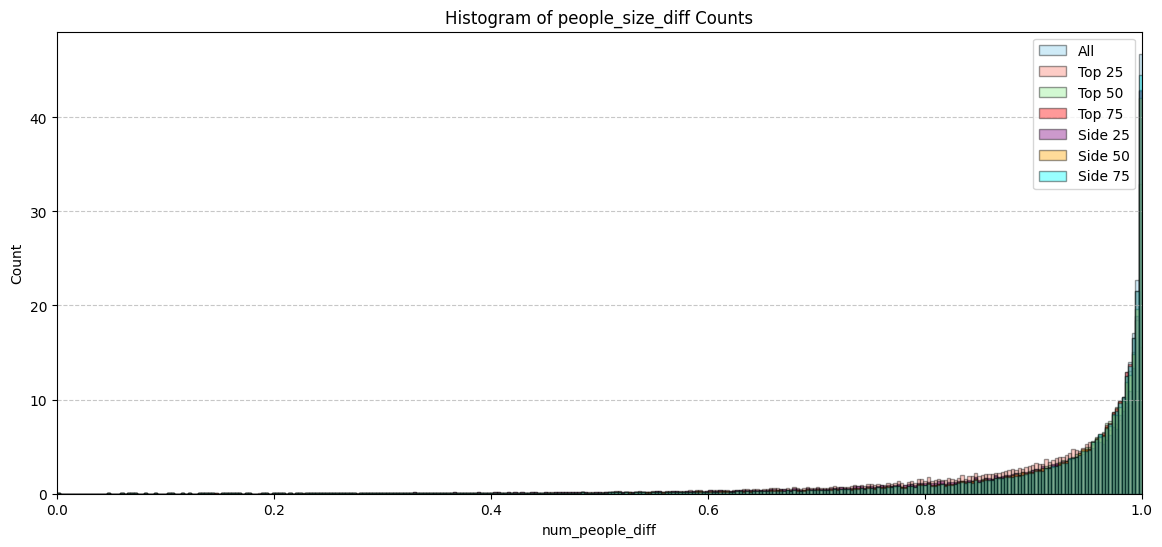

In [379]:
colors = ["skyblue", "salmon", "lightgreen", "red", "purple", "orange", "cyan"]


plt.figure(figsize=(14, 6))

for i, (df_temp, color) in enumerate(zip(df_list, colors)):
    plt.hist(df_temp['people_size_diff'], bins=400, color=color, edgecolor="black", alpha=0.4, density=True)
    plt.xlabel("people_size_diff")
    plt.ylabel("Count")

plt.xlabel("num_people_diff")
plt.ylabel("Count")
plt.title("Histogram of people_size_diff Counts")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xlim(0,1)
plt.legend(df_names)
plt.show()


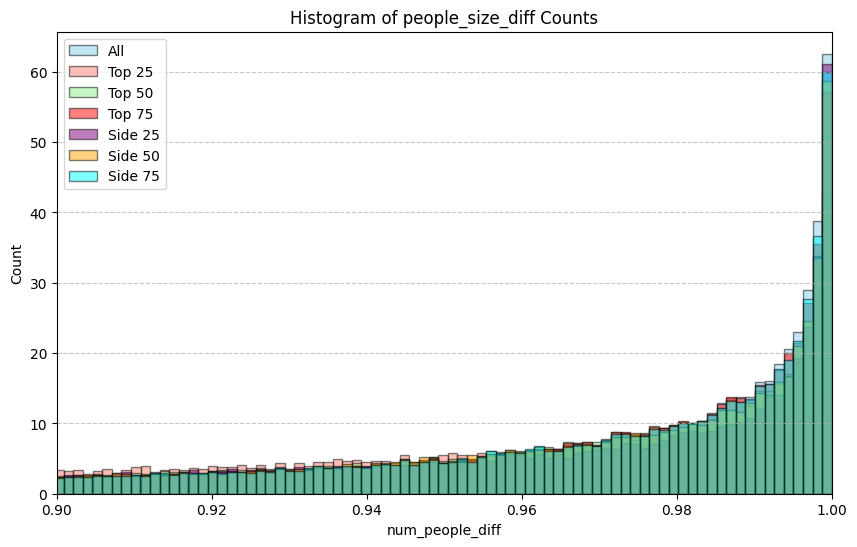

In [380]:
plt.figure(figsize=(10, 6))

for i, (df_temp, color) in enumerate(zip(df_list, colors)):
    plt.hist(df_temp['people_size_diff'], bins=1000, color=color, edgecolor="black", alpha=0.5, density=True)
    plt.xlabel("people_size_diff")
    plt.ylabel("Count")

plt.xlabel("num_people_diff")
plt.ylabel("Count")
plt.title("Histogram of people_size_diff Counts")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xlim(0.9,1)
plt.legend(df_names)
plt.show()


### visibility_dif

In [381]:
def plot_visibility_dif(df, title):
    plt.hist(df['visibility_dif'], bins=200, color="skyblue", edgecolor="black", alpha=0.7, density=True)
    plt.xlabel("visibility_dif")
    plt.ylabel("Count")
    plt.title(f"{title}")
    plt.grid(axis="y", linestyle="--", alpha=0.7)

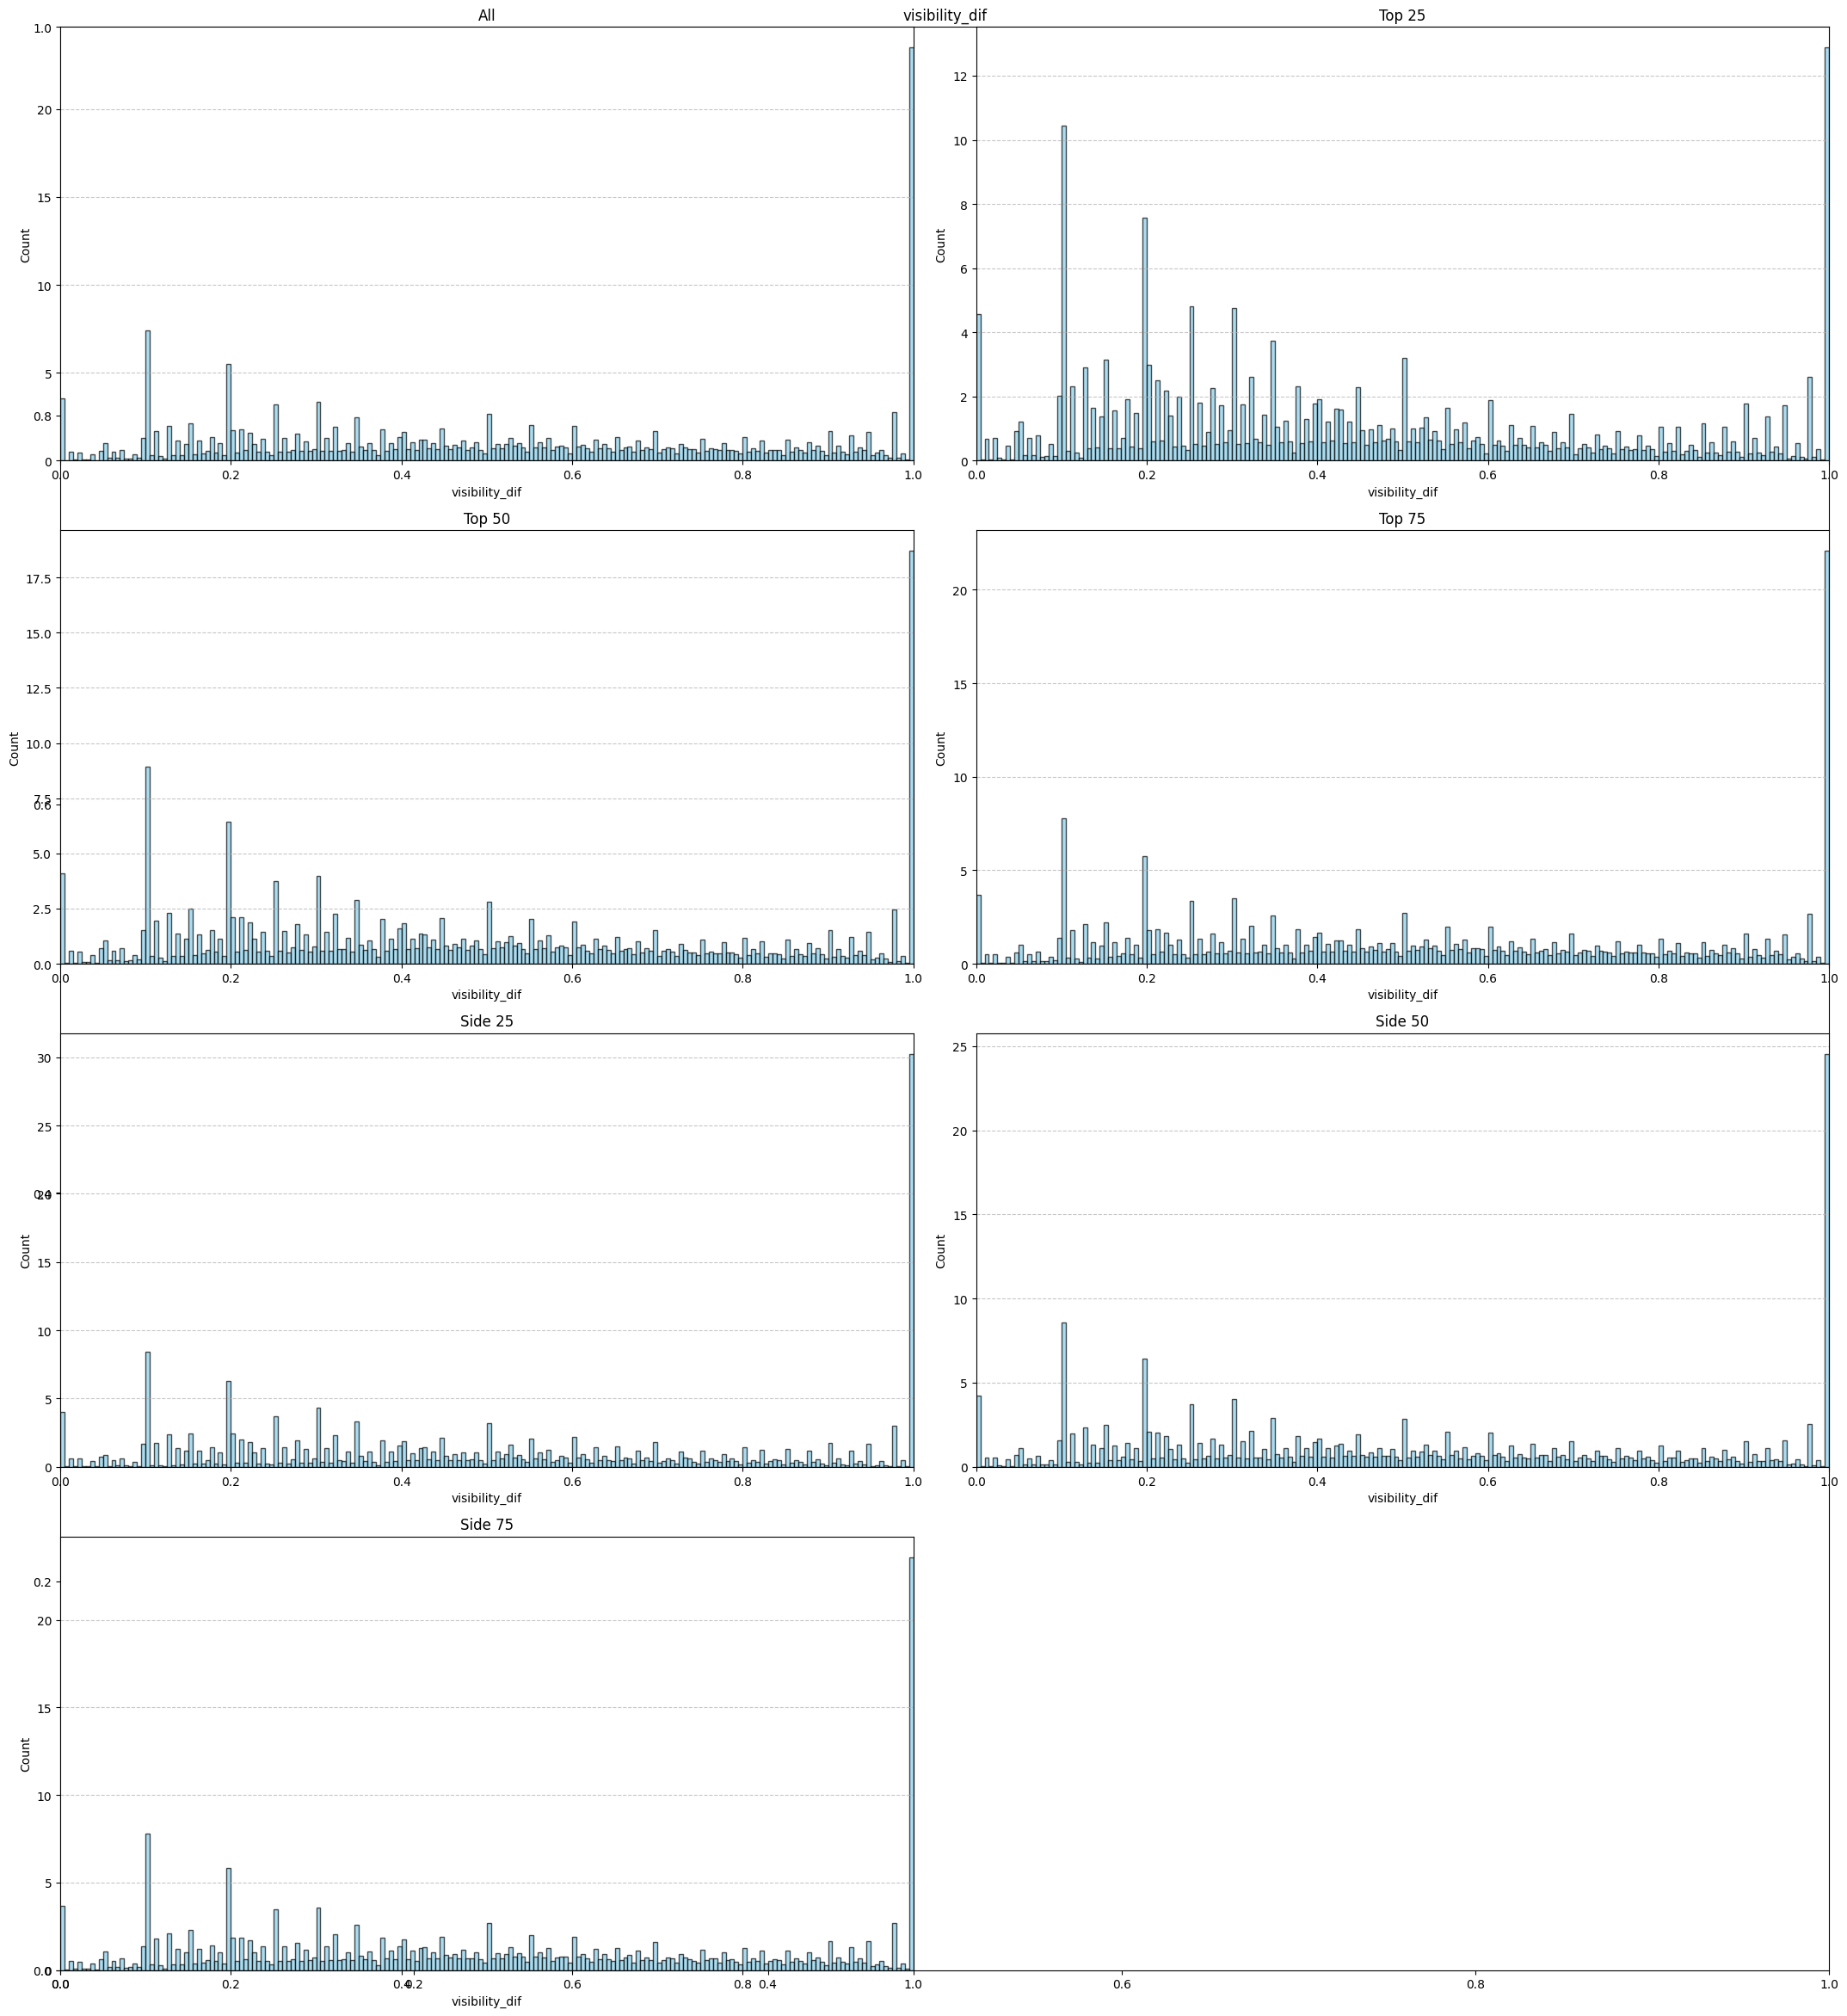

In [382]:
plt.figure(figsize=(22, 24))
plt.title(f"visibility_dif")
for index, data in enumerate(zip(df_list, df_names)):
    ax = plt.subplot(4, 2, index+1)
    plot_visibility_dif(data[0], data[1])
    ax.set_xlim(0, 1) 
plt.tight_layout()

plt.show()

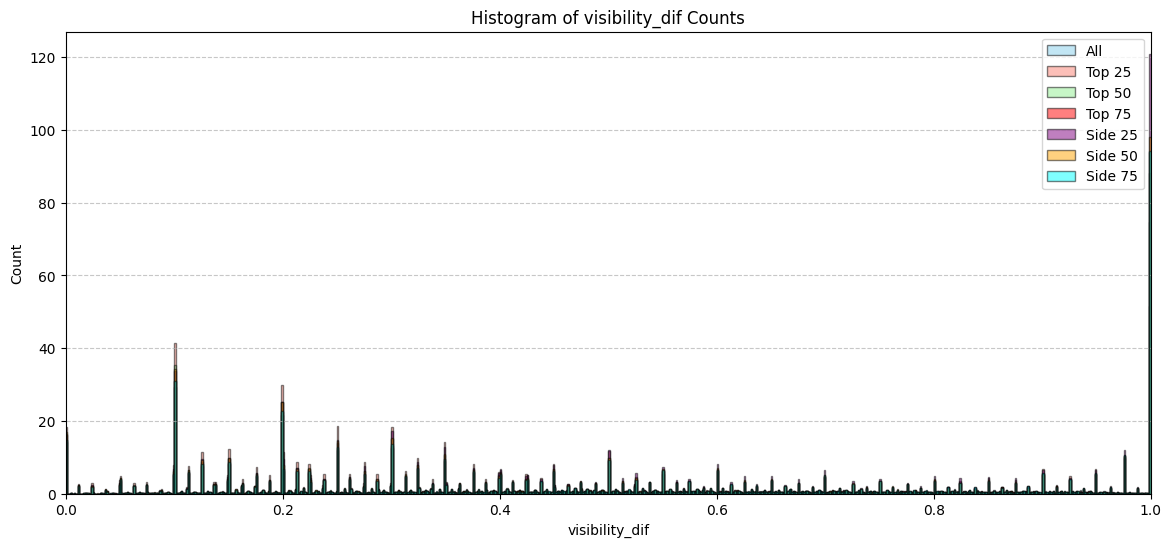

In [383]:
plt.figure(figsize=(14, 6))

for i, (df_temp, color) in enumerate(zip(df_list, colors)):
    plt.hist(df_temp['visibility_dif'], bins=800, color=color, edgecolor="black", alpha=0.5, density=True)
    plt.xlabel("visibility_dif")
    plt.ylabel("Count")

plt.xlabel("visibility_dif")
plt.ylabel("Count")
plt.title("Histogram of visibility_dif Counts")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xlim(0,1)
plt.legend(df_names)
plt.show()


### offset_diff

### total_dif

In [384]:
def plot_total_dif(df, title):
    plt.hist(df['total_dif'], bins=200, color="skyblue", edgecolor="black", alpha=0.7, density=True)
    plt.xlabel("total_dif")
    plt.ylabel("Count")
    plt.title(f"{title}")
    plt.grid(axis="y", linestyle="--", alpha=0.7)

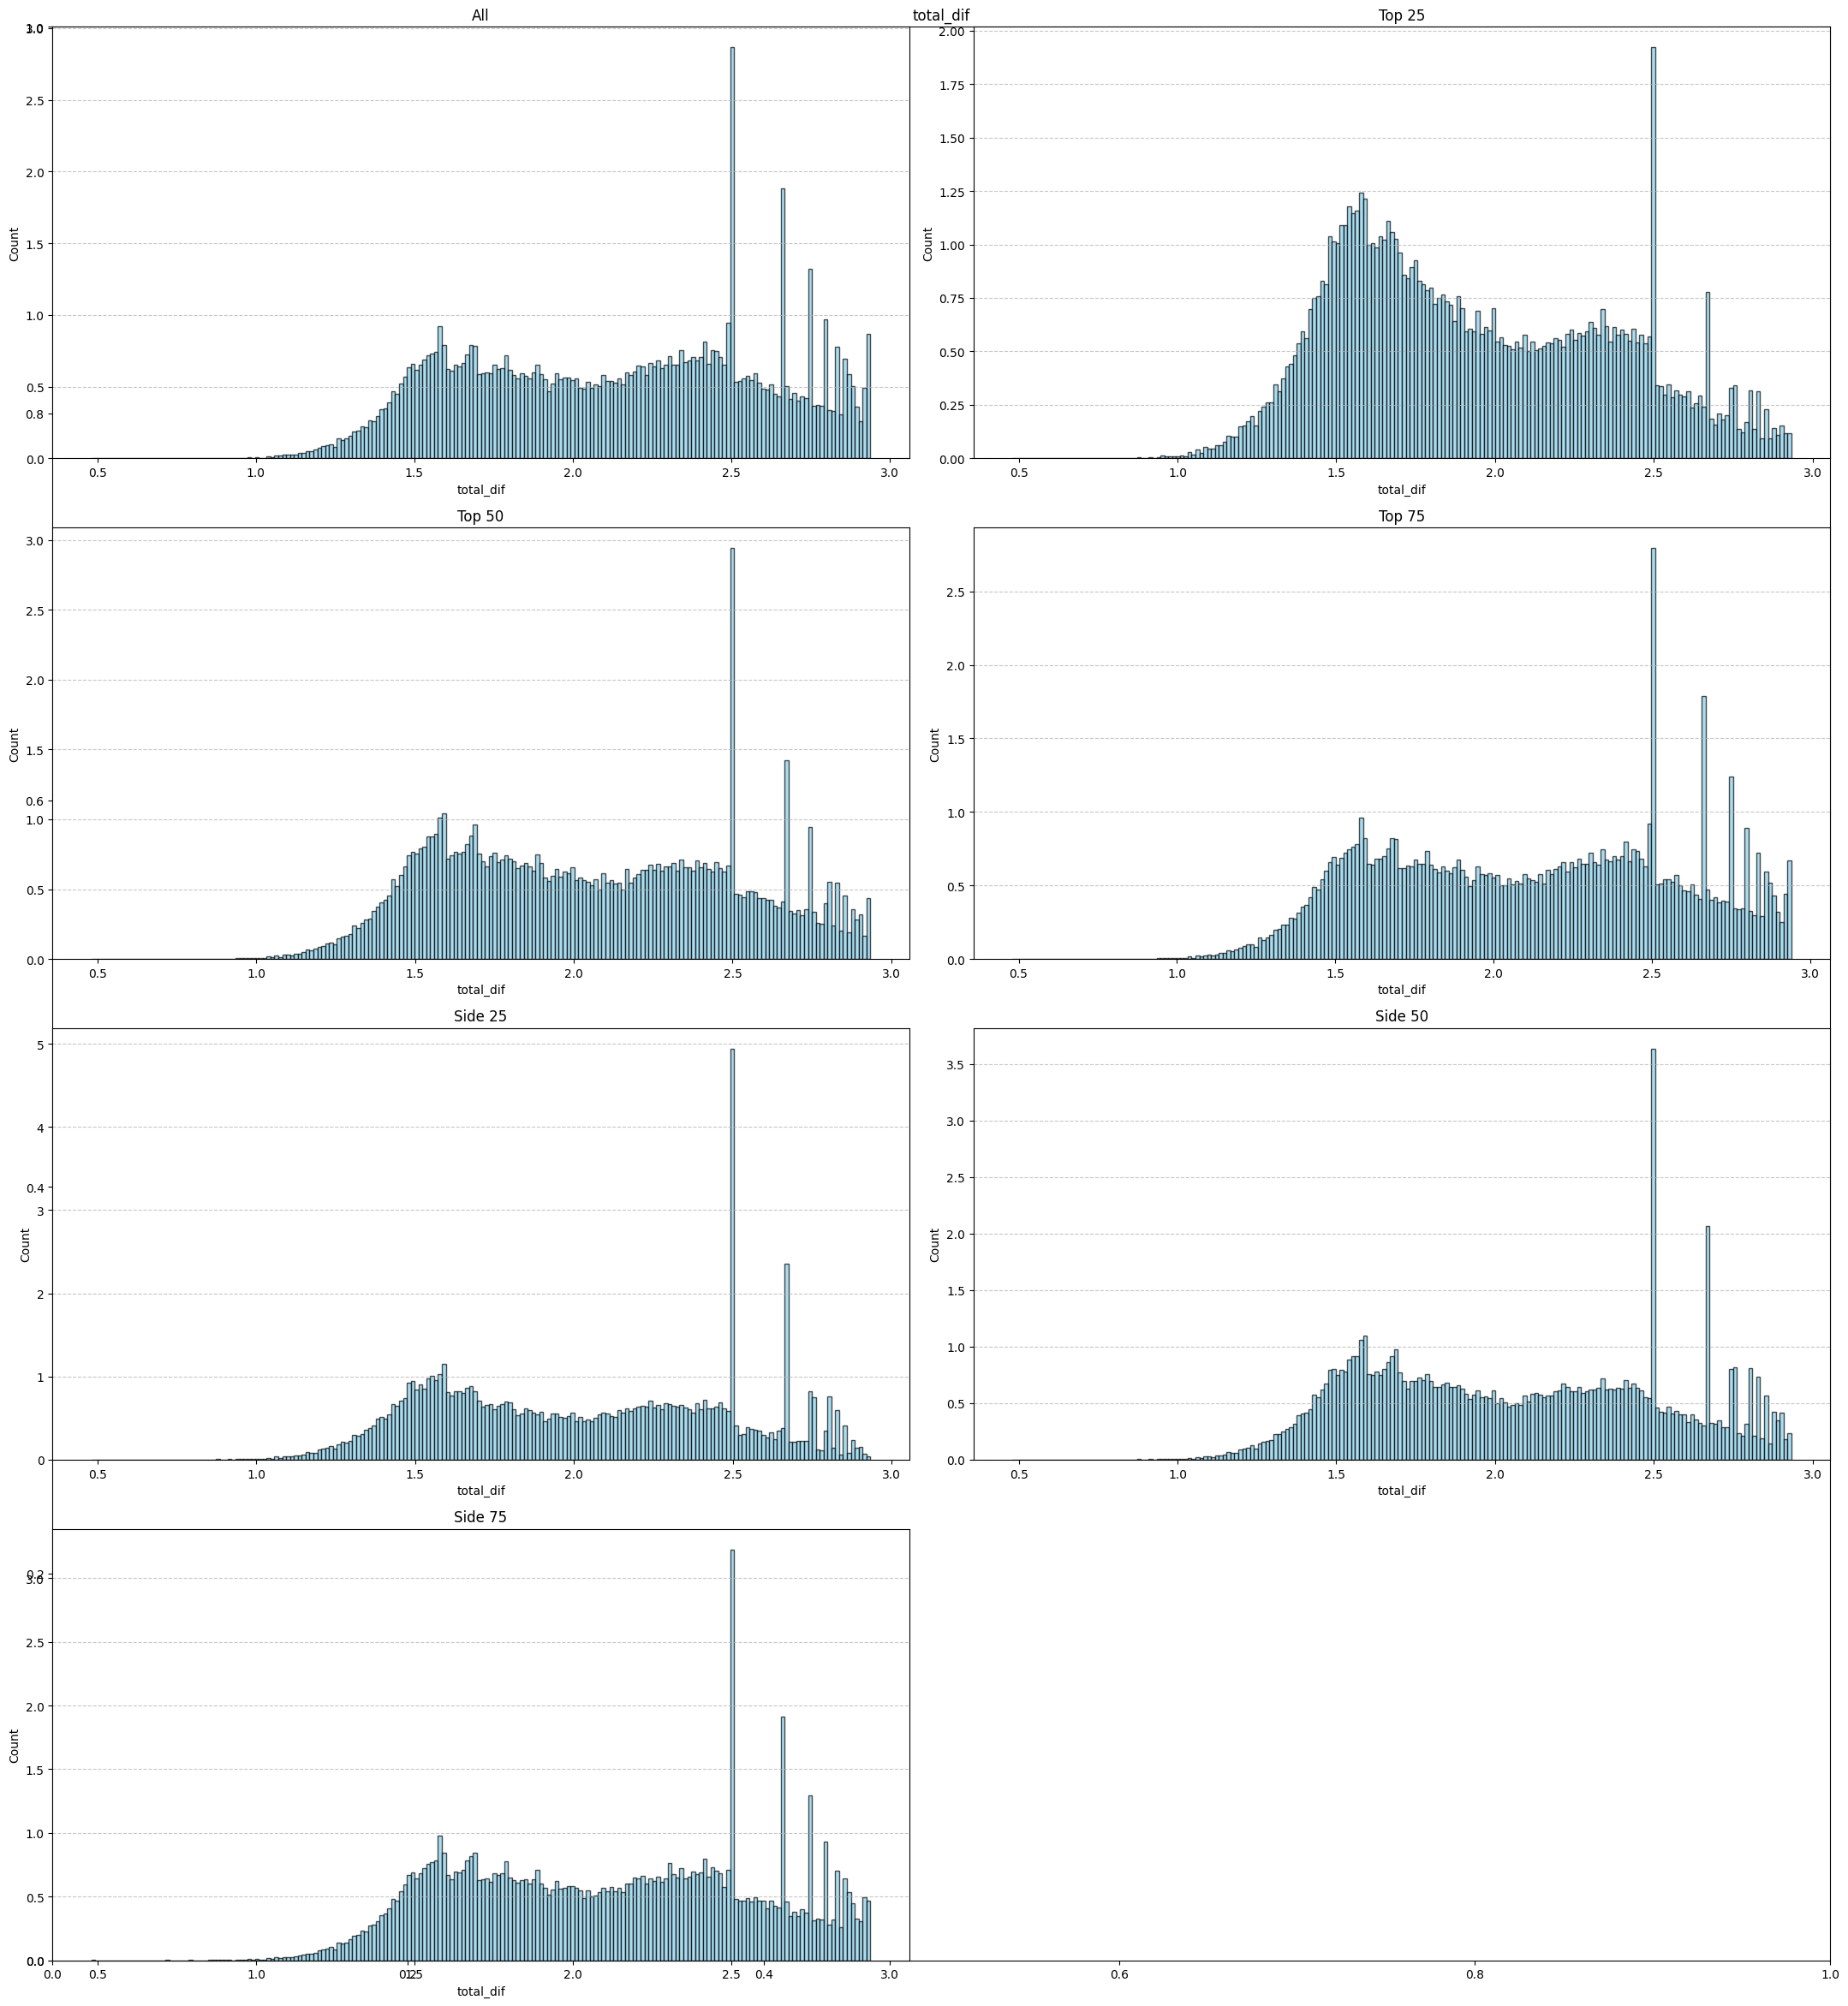

In [387]:
plt.figure(figsize=(22, 24))
plt.title(f"total_dif")
for index, data in enumerate(zip(df_list, df_names)):
    ax = plt.subplot(4, 2, index+1)
    plot_total_dif(data[0], data[1])
plt.tight_layout()

plt.show()

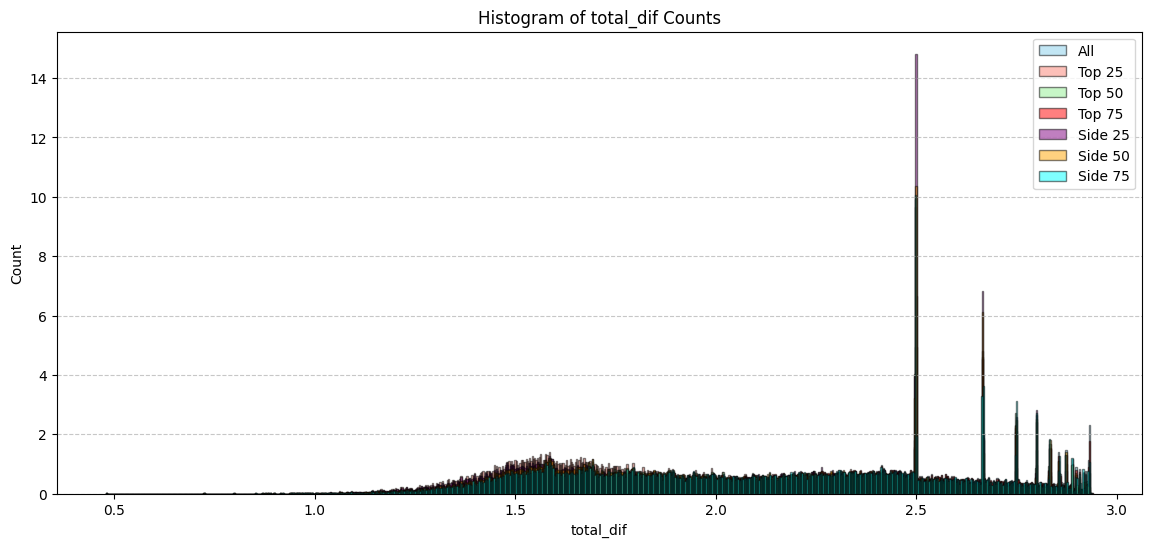

In [388]:
plt.figure(figsize=(14, 6))

for i, (df_temp, color) in enumerate(zip(df_list, colors)):
    plt.hist(df_temp['total_dif'], bins=800, color=color, edgecolor="black", alpha=0.5, density=True)
    plt.xlabel("total_dif")
    plt.ylabel("Count")

plt.xlabel("total_dif")
plt.ylabel("Count")
plt.title("Histogram of total_dif Counts")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(df_names)
plt.show()
